# Top

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings
import duckdb

warnings.simplefilter(action="ignore", category=FutureWarning)

# Loading

Let's load the parquetfile we saved in notebook 1. You will need to change the filename in the config file!

In [122]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp-20250910-235500.parq',
 'inputpath': 'your-path-here.csv',
 'datetime_format': '%d/%m/%Y, %H:%M:%S',
 'drop_authors': []}

In [123]:
root = Path("..").resolve()
processed = root / Path(config["processed"])
datafile = processed / config["current"]
if not datafile.exists():
    logger.warning(
        f"{datafile} does not exist. First run src/preprocess.py, and check the timestamp!"
    )

Note how datatypes have been preserved.

In [124]:
df = pd.read_parquet(datafile)
df.dtypes

timestamp             datetime64[ns, UTC]
message                            object
author                             object
has_emoji                            bool
is_topk                              bool
message_length                      int64
has_link                             bool
timestamp_category               category
hour                               object
day_of_week                         int32
dtype: object

# Explore

## Compare word

In [125]:
"""
selects the top 15 most active authors
"""

p1 = (
    df[["author", "message"]]
    .groupby("author")
    .count()
    .sort_values("message", ascending=False)
)

k = 15
topk = p1[:k]

In [126]:
# Selects the top 15 authors which mentioned "lift" in their messages
p1_lift = (
    df[df["message"].str.contains("lift", case=False)]
    .groupby("author")
    .count()[["message"]]
    .sort_values("message", ascending=False)
)

# Select top 15 authors (index) who mentioned "lift", based on message count
k = 15
topk_lift = p1_lift.head(k)
# p1_lift


In [127]:
# topk_authors = list(topk.index)
# topk_authors

In [128]:
# Selects the top 15 authors which mentioned "lift" in their messages
topk_authors_lift = list(topk_lift.index)
# topk_authors

In [129]:
""" 
new column in the DataFrame called "is_topk"
For each row, it checks if the "author" is in the list of the top 15 most active authors which mentioned 'lift' (topk_authors_lift). 
If the author is in the top 15, the value is True; otherwise, it is False. 
This allows you to easily filter or analyze messages from the most active participants.
"""

df["is_topk"] = df["author"].apply(lambda x: x in topk_authors_lift)
# df.head(20)

# If you want True first, False last:
# df = df.sort_values(by=["is_topk", "message_length"], ascending=False)
# df.head(20)

Text(0.5, 1.0, "Sending the most messages containing 'lift'...")

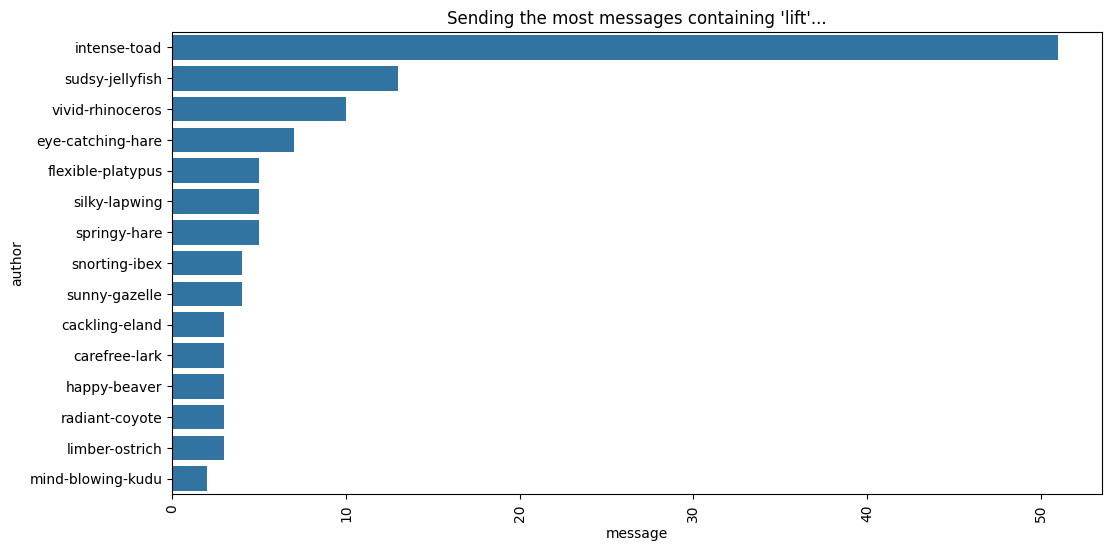

In [130]:
plt.figure(figsize=(12, 6))
sns.barplot(y=p1_lift.index[:k], x="message", data=topk_lift)
plt.xticks(rotation=90)
plt.title("Sending the most messages containing 'lift'...")

## Distribution of message

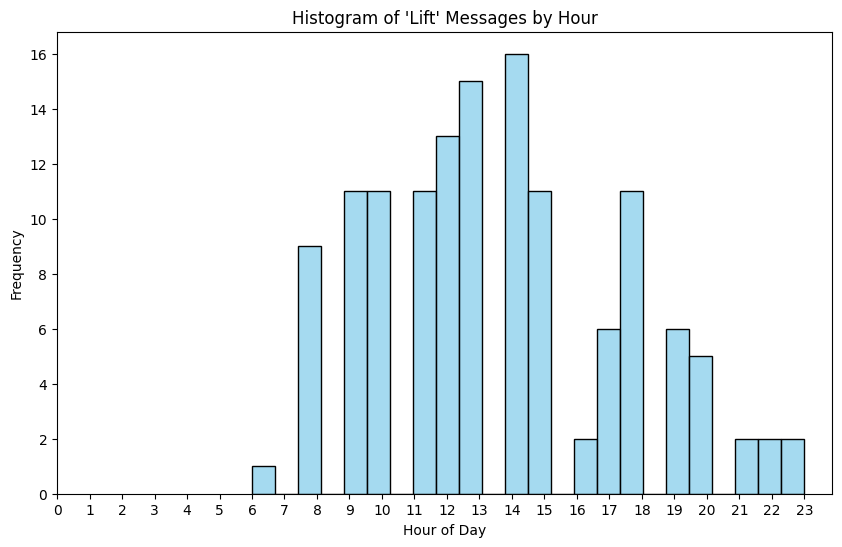

In [131]:
# Vraag: Op welke tijdstippen (of dagen van de week) wordt het meest over de lift gepraat?
# Extract the hours for messages containing "lift"
# Ensure 'hour' is numeric
df["hour"] = df["timestamp"].dt.hour  # this should already give integers

# Extract hours for messages containing "lift" and convert to int
lift_hours = df[df["message"].str.contains("lift", case=False)]["hour"].astype(int)

# Plot histogram using Seaborn
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(lift_hours, bins=24, kde=False, color="skyblue")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency")
plt.title("Histogram of 'Lift' Messages by Hour")
plt.xticks(range(0, 24))
plt.show()


## Trend

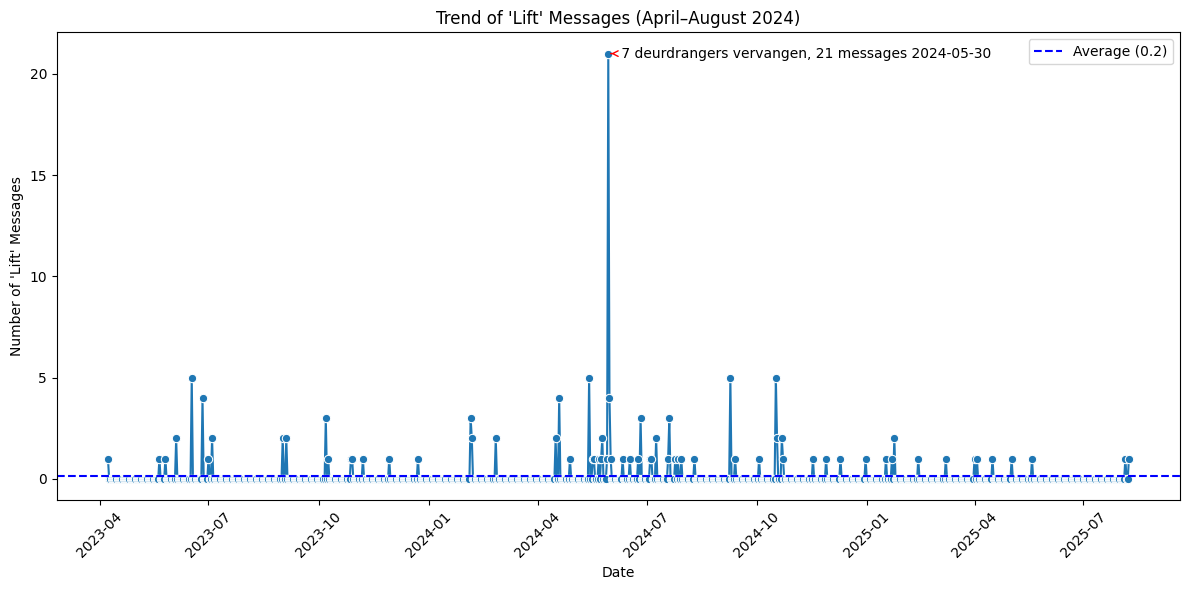

In [139]:
# "Vandaag zijn onverwacht 7 deurdrangers van lift 1 vervangen" 

import seaborn as sns
import matplotlib.pyplot as plt

# Filter messages containing 'lift'
lift_df = df[df["message"].str.contains("lift", case=False)]

# Filter for 2024 and months April (4) to August (8)
# lift_df = lift_df[
#     (lift_df["timestamp"].dt.year == 2024) &
#     (lift_df["timestamp"].dt.month >= 4) &
#     (lift_df["timestamp"].dt.month <= 8)
# ]

# Aggregate by day
lift_trend = lift_df.set_index("timestamp").resample("D").size().reset_index(name="count")


# Find the date with the maximum count
max_row = lift_trend.loc[lift_trend["count"].idxmax()]

max_date = max_row["timestamp"].strftime("%Y-%m-%d")
max_count = max_row["count"]


# Plot trendline
plt.figure(figsize=(12, 6))
sns.lineplot(data=lift_trend, x="timestamp", y="count", marker="o")
plt.xlabel("Date")
plt.ylabel("Number of 'Lift' Messages") 
plt.title("Trend of 'Lift' Messages (April–August 2024)")
plt.xticks(rotation=45)


# Add average line
avg_count = lift_trend["count"].mean()
plt.axhline(y=avg_count, color="blue", linestyle="--", linewidth=1.5, label=f"Average ({avg_count:.1f})")



# Annotate the peak point (to the right of the peak)
plt.annotate(
    f" 7 deurdrangers vervangen, {max_count} messages {max_date}",
    xy=(max_row["timestamp"], max_count),
    xytext=(max_row["timestamp"] + pd.Timedelta(days=7), max_count),  # 7 days to the right
    arrowprops=dict(arrowstyle="->", color="red"),
    va="center"
)

plt.legend()
plt.tight_layout()
plt.show()


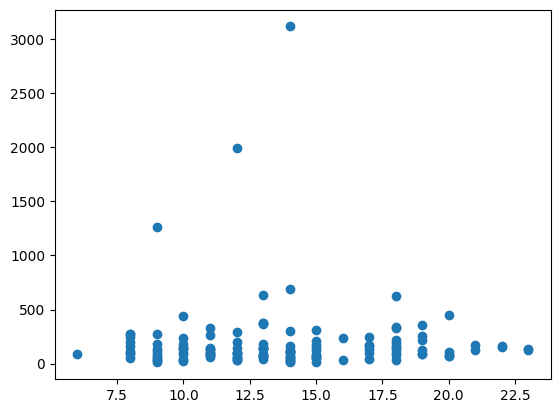

In [133]:
# Bestaat er een relatie tussen de lengte van berichten en het tijdstip waarop ze gestuurd worden?
# Resultaat: Scatter laat zien of late-night berichten langer/emotioneler zijn, of korte frustratieberichten vaak ’s ochtends komen.

df["msg_length"] = df["message"].str.len()
lift_msgs = df[df["message"].str.contains("lift", case=False)]
plt.scatter(lift_msgs["hour"], lift_msgs["msg_length"])

In [135]:
datafile

PosixPath('/Users/luiginocleofa/1_HU_Post_HBO_AI/DAV/MADS-DAV/data/processed/whatsapp-20250910-235500.parq')

In [136]:
df.to_parquet(datafile, index=False)